In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR

##Data Preprocessing

In [67]:
# data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Separate features and target variable
X = data.drop(columns=["DEATH_EVENT"])
y = data["DEATH_EVENT"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model 3: weight-tuning_EB_LG
### Check if the error is less than the error_criterion (0.3), and then check if the epoch is >=50

In [68]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and data loaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network model with only one output node
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        init.xavier_uniform_(self.fc1.weight)  # Xavier initialization for weights of fc1
        self.bn = nn.BatchNorm1d(hidden_size)  # Batch normalization layer
        self.fc2 = nn.Linear(hidden_size, 1)
        init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)  # Using ReLU activation function
        x = self.fc2(x)
        return x

input_size = X_train_tensor.shape[1]
hidden_size = 8
model3 = NeuralNetwork(input_size, hidden_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.95)

# Define the error value criterion
error_criterion = 0.5


# Counters for acceptable and unacceptable cases
acceptable_cases = 0
unacceptable_cases = 0

# Training process with epochs
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model3(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        print("Original Loss:", loss.item())

        # Check if the loss is smaller than the error value criterion
        if loss.item() < error_criterion:
            print("An acceptable case")
            acceptable_cases +=1
            break

        loss.backward()
        optimizer.step()
        print("An unacceptable case")
        unacceptable_cases +=1

    if epoch >= 50:
        print("An unacceptable 2LNN")
        break


# Output the counts of acceptable and unacceptable cases
print(f"Total acceptable cases: {acceptable_cases}")
print(f"Total unacceptable cases: {unacceptable_cases}")

Original Loss: 0.6792861819267273
An unacceptable case
Original Loss: 0.6478989720344543
An unacceptable case
Original Loss: 0.600527286529541
An unacceptable case
Original Loss: 0.6197647452354431
An unacceptable case
Original Loss: 0.5916355848312378
An unacceptable case
Original Loss: 0.5920801758766174
An unacceptable case
Original Loss: 0.6028805375099182
An unacceptable case
Original Loss: 0.5300416946411133
An unacceptable case
Original Loss: 0.6177431344985962
An unacceptable case
Original Loss: 0.5162614583969116
An unacceptable case
Original Loss: 0.4821203052997589
An acceptable case
Original Loss: 0.5616051554679871
An unacceptable case
Original Loss: 0.4852052628993988
An acceptable case
Original Loss: 0.49942174553871155
An acceptable case
Original Loss: 0.5829817056655884
An unacceptable case
Original Loss: 0.49007827043533325
An acceptable case
Original Loss: 0.48346102237701416
An acceptable case
Original Loss: 0.5424502491950989
An unacceptable case
Original Loss: 0.4

## Test Model 3

In [69]:
# Test the model
model3.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model3(X_test_tensor).squeeze()  # Remove the extra dimension
    predicted = (outputs >= 0.5).float()  # Applying threshold of 0.5 for binary classification
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.6


## save model

In [70]:
model_path = "accepable_model_EB_LG.pth"

# Save the final model's parameters
torch.save(model3.state_dict(), model_path)
print(f"Model parameters saved to {model_path}")

# Load the saved model parameters to continue training
model = NeuralNetwork(input_size, hidden_size)
model.load_state_dict(torch.load(model_path))
print("Model parameters loaded from", model_path)

Model parameters saved to accepable_model_EB_LG.pth
Model parameters loaded from accepable_model_EB_LG.pth


## Cramming_Ri_LG1_SO_MU

#### the correct code

In [71]:
# Define the extended neural network class
class ExtendedNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ExtendedNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Training and handling unacceptable cases
num_unacceptable_cases = 19
extra_hidden_size = 3

# Iterate through the unacceptable cases
for unacceptable_case in range(num_unacceptable_cases):
    # Create an extended model with additional hidden nodes
    hidden_size += extra_hidden_size
    extended_model = ExtendedNeuralNetwork(input_size, hidden_size)

    # Copy the parameters from the base model to the extended model
    with torch.no_grad():
        extended_model.fc1.weight[:hidden_size-extra_hidden_size, :] = model.fc1.weight
        extended_model.fc1.bias[:hidden_size-extra_hidden_size] = model.fc1.bias
        extended_model.fc2.weight[:, :hidden_size-extra_hidden_size] = model.fc2.weight
        extended_model.fc2.bias = model.fc2.bias

    # Set up optimizer and loss function for the extended model
    optimizer_extended = optim.Adam(extended_model.parameters(), lr=0.01)

    # Retrain the extended model on the entire training data to generalize
    num_retrain_epochs = 10
    for epoch in range(num_retrain_epochs):
        for inputs, labels in train_loader:
            optimizer_extended.zero_grad()
            output = extended_model(inputs).squeeze()
            loss_extended = criterion(output, labels.float())
            loss_extended.backward()
            optimizer_extended.step()

    # Save the extended model's parameters
    extended_model_path = f"extended_model_case_{unacceptable_case + 1}.pth"
    torch.save(extended_model.state_dict(), extended_model_path)
    print(f"Extended model parameters saved to {extended_model_path}")

    # Reload the extended model for the next iteration
    model = ExtendedNeuralNetwork(input_size, hidden_size)
    model.load_state_dict(torch.load(extended_model_path))
    print(f"Extended model reloaded for the next iteration")

# Save the final extended model after all unacceptable cases
final_extended_model_path = f"final_extended_model.pth"
torch.save(extended_model.state_dict(), final_extended_model_path)
print(f"Final extended model parameters saved to {final_extended_model_path}")

Extended model parameters saved to extended_model_case_1.pth
Extended model reloaded for the next iteration
Extended model parameters saved to extended_model_case_2.pth
Extended model reloaded for the next iteration
Extended model parameters saved to extended_model_case_3.pth
Extended model reloaded for the next iteration
Extended model parameters saved to extended_model_case_4.pth
Extended model reloaded for the next iteration
Extended model parameters saved to extended_model_case_5.pth
Extended model reloaded for the next iteration
Extended model parameters saved to extended_model_case_6.pth
Extended model reloaded for the next iteration
Extended model parameters saved to extended_model_case_7.pth
Extended model reloaded for the next iteration
Extended model parameters saved to extended_model_case_8.pth
Extended model reloaded for the next iteration
Extended model parameters saved to extended_model_case_9.pth
Extended model reloaded for the next iteration
Extended model parameters sa

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Define the ExtendedNeuralNetwork class
class ExtendedNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, extra_hidden_size=0):
        super(ExtendedNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size + extra_hidden_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn = nn.BatchNorm1d(hidden_size + extra_hidden_size)
        self.fc2 = nn.Linear(hidden_size + extra_hidden_size, 1)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Path to the saved extended model
extended_model_path = "final_extended_model.pth"

# Number of unacceptable cases
num_unacceptable_cases = 19

# Calculate the final number of hidden nodes
initial_hidden_size = 8
extra_hidden_size = 3
final_hidden_size = initial_hidden_size + (extra_hidden_size * num_unacceptable_cases)

# Instantiate the extended model with the correct number of hidden nodes
input_size = X_train_tensor.shape[1]
extended_model = ExtendedNeuralNetwork(input_size, final_hidden_size - extra_hidden_size, extra_hidden_size)

# Load the state dictionary
extended_model.load_state_dict(torch.load(extended_model_path))
print(f"Extended model parameters loaded from {extended_model_path}")

# Set the model to evaluation mode
extended_model.eval()

# Define the test dataset and data loader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            outputs = model(inputs).squeeze()
            probs = torch.sigmoid(outputs)
            predictions = torch.round(probs)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions.numpy())
            all_probs.extend(probs.numpy())

    accuracy = correct / total
    return accuracy, all_labels, all_predictions, all_probs

# Calculate accuracy on the test set
test_accuracy, all_labels, all_predictions, all_probs = calculate_accuracy(extended_model, test_loader)
print(f"Accuracy of the extended model on the test set: {test_accuracy * 100:.2f}%")


Extended model parameters loaded from final_extended_model.pth
Accuracy of the extended model on the test set: 68.33%


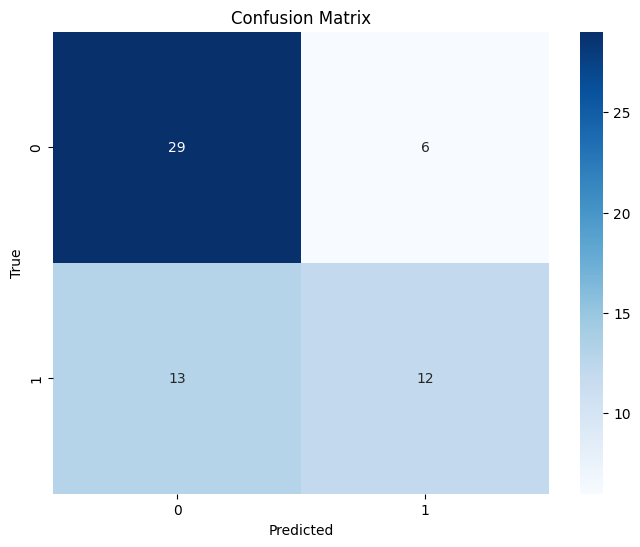

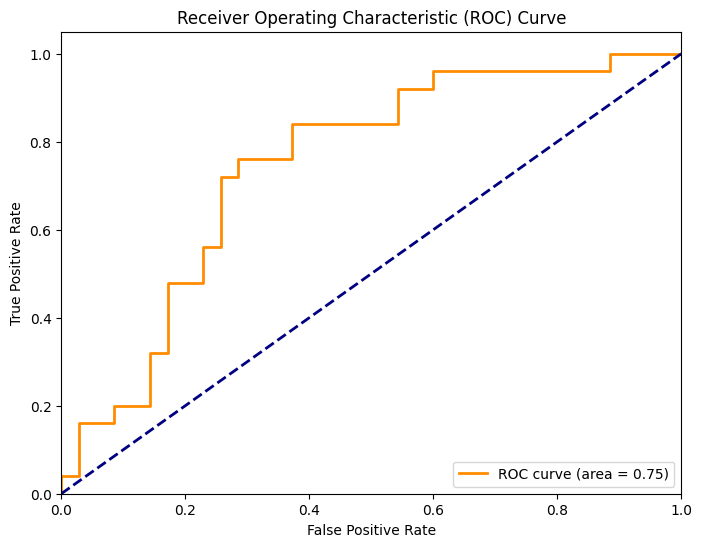

In [73]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


#### the wrong code, but better result

Extended model parameters loaded from extended_model_case_24.pth
Accuracy of the extended model on the test set: 73.33%


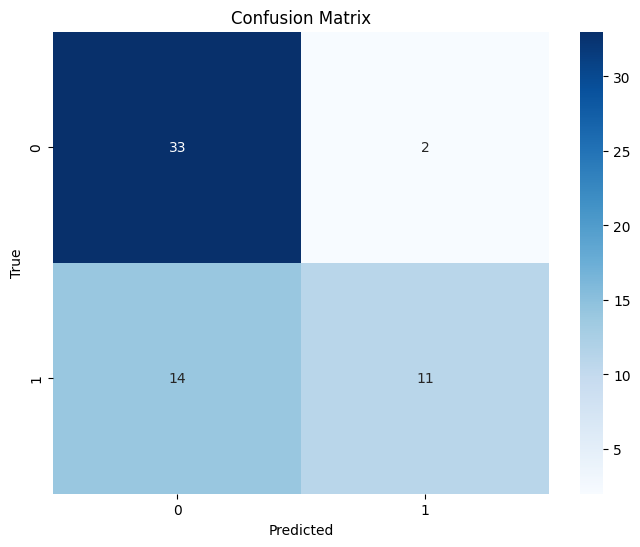

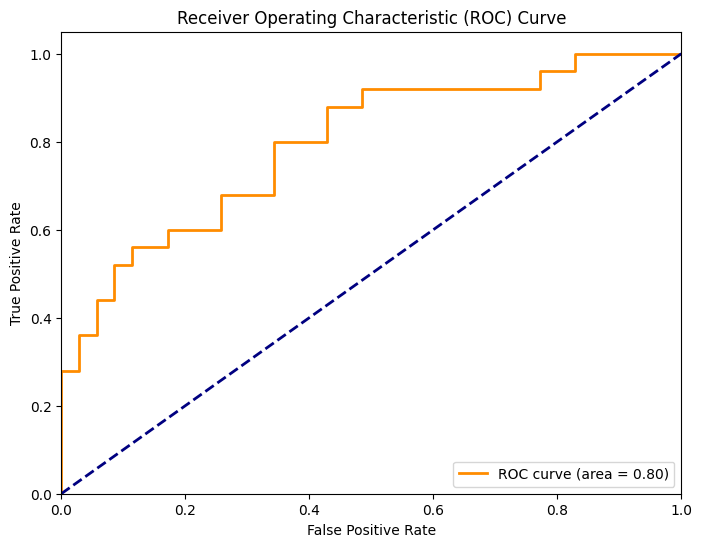

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Define the ExtendedNeuralNetwork class (same as before)
class ExtendedNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, extra_hidden_size=3):
        super(ExtendedNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size + extra_hidden_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn = nn.BatchNorm1d(hidden_size + extra_hidden_size)
        self.fc2 = nn.Linear(hidden_size + extra_hidden_size, 1)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Path to the saved extended model
extended_model_path = "extended_model_case_24.pth"

# Instantiate the extended model
input_size = X_train_tensor.shape[1]
hidden_size = 8
extended_model = ExtendedNeuralNetwork(input_size, hidden_size)

# Load the state dictionary
extended_model.load_state_dict(torch.load(extended_model_path))
print(f"Extended model parameters loaded from {extended_model_path}")

# Set the model to evaluation mode
extended_model.eval()

# Define the test dataset and data loader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Collect predictions and true labels
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = extended_model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        predictions = torch.round(probs)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predictions.numpy())
        all_probs.extend(probs.numpy())

# Calculate accuracy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
accuracy = (all_predictions == all_labels).mean()
print(f"Accuracy of the extended model on the test set: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
